Implements DeepPCR, a novel algorithm which parallelizes typically sequential operations in order to speed up inference and training of neural networks.
https://machinelearning.apple.com/research/deeppcr

<img src="assets/deepprc.png" />

Epoch: 5/5, Batch 937, Loss: 0.0468

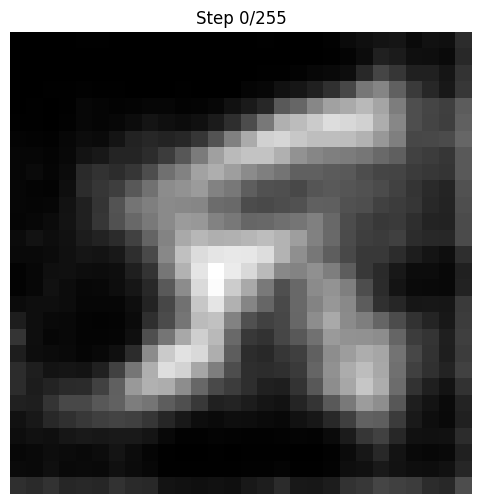

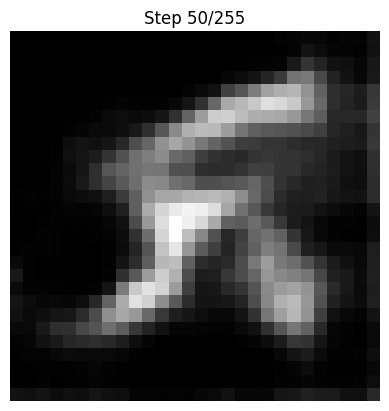

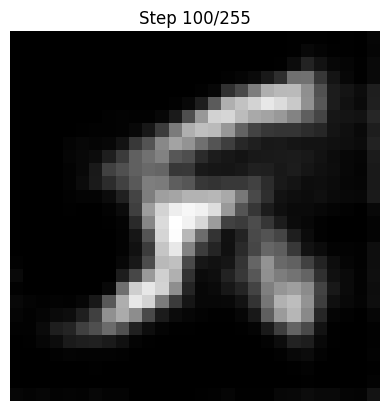

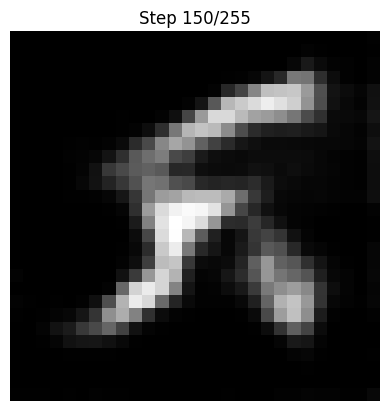

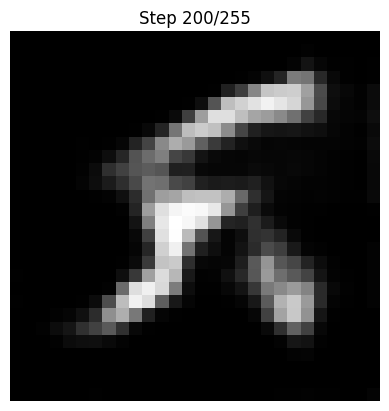

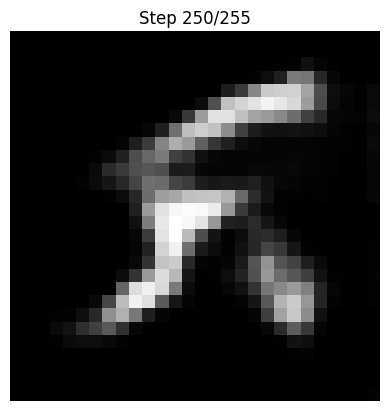

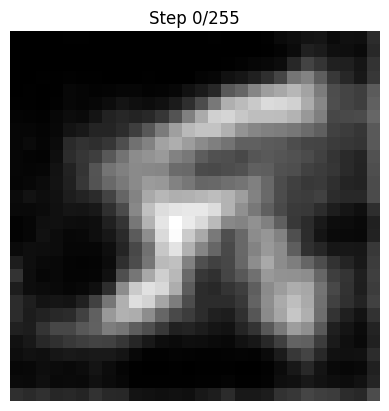

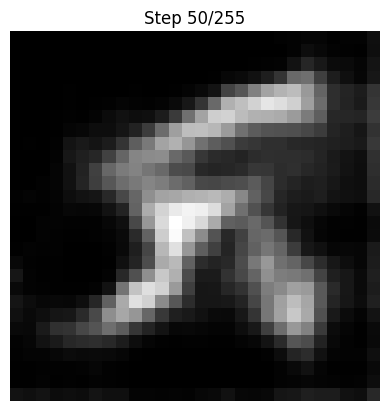

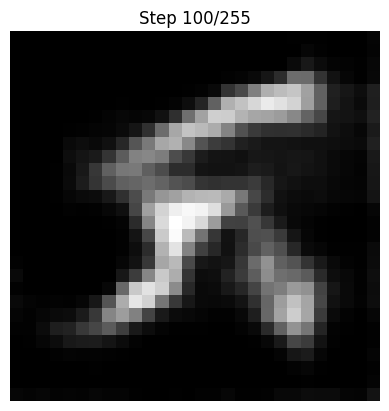

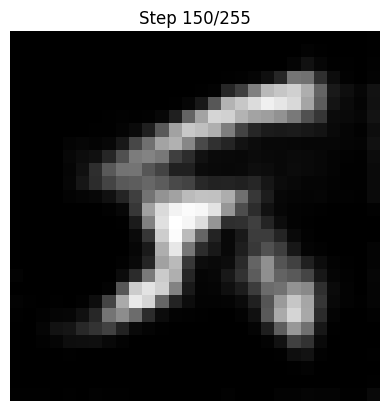

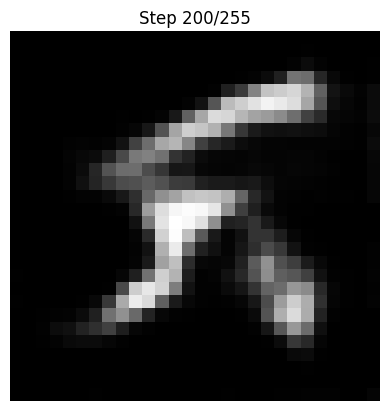

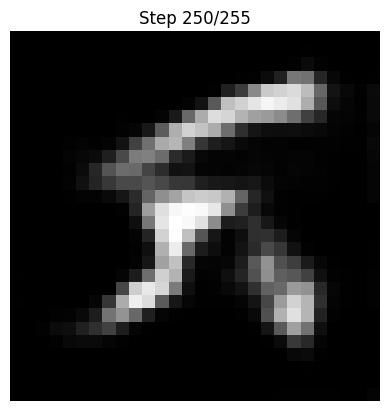

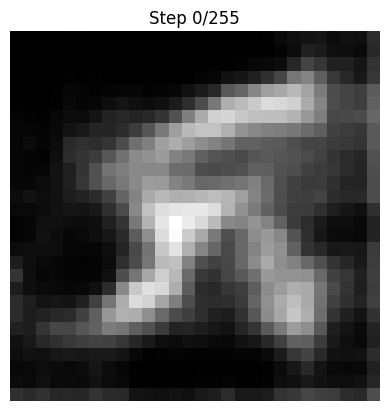

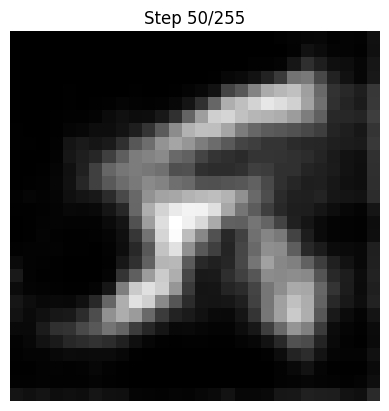

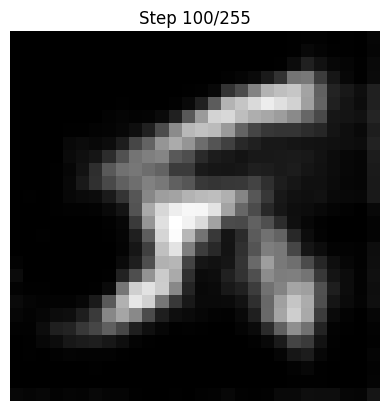

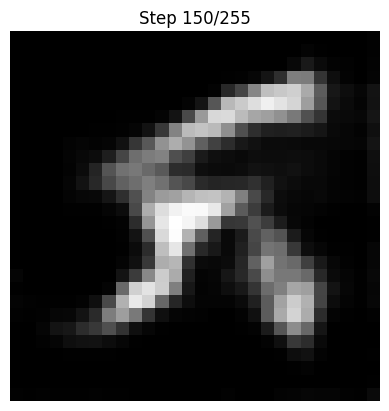

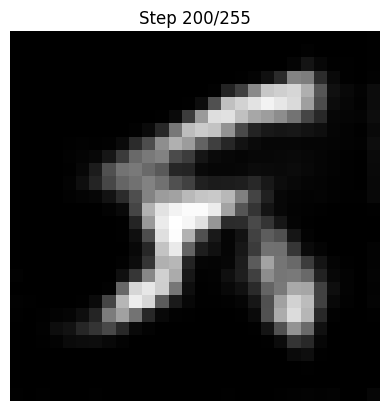

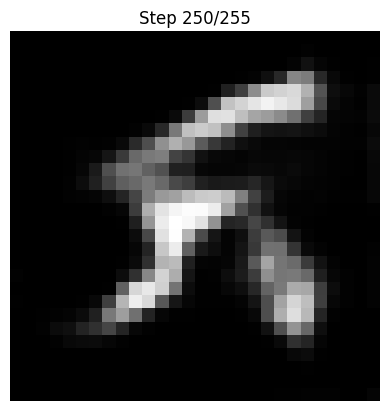

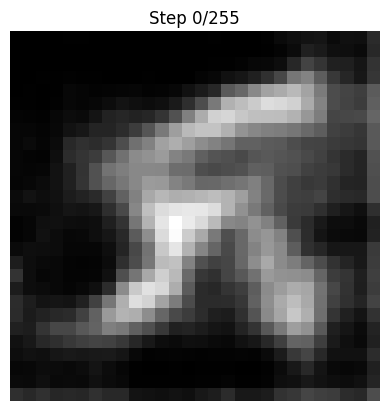

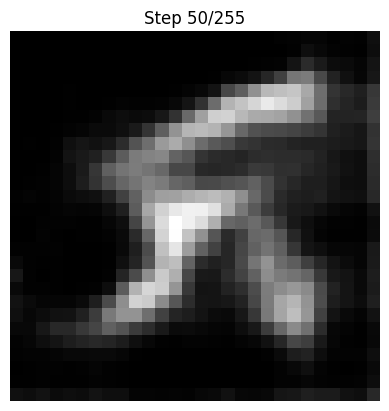

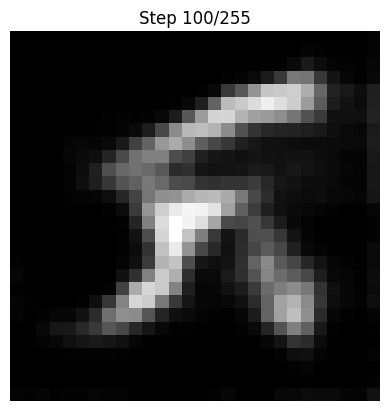

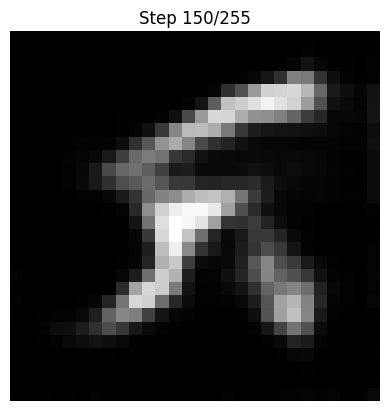

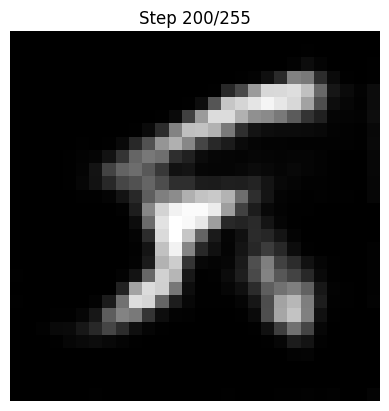

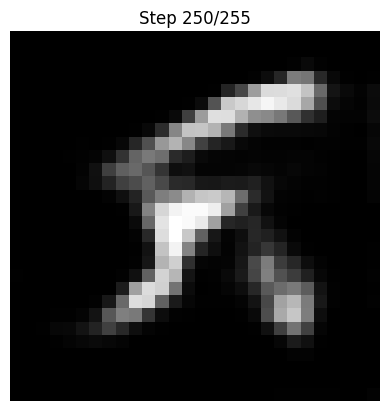

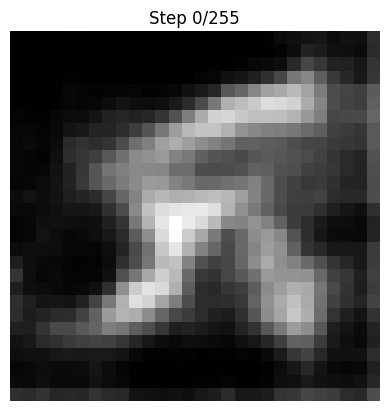

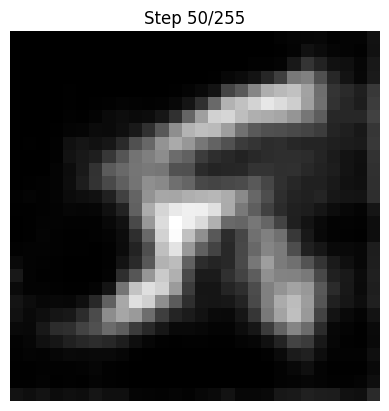

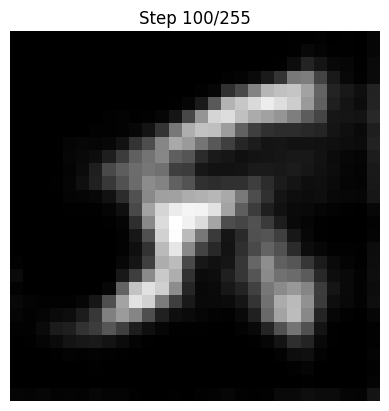

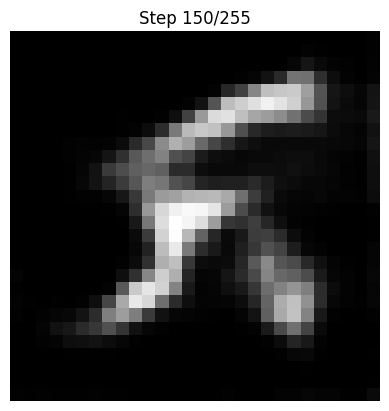

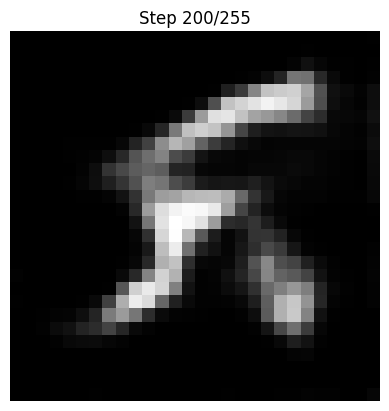

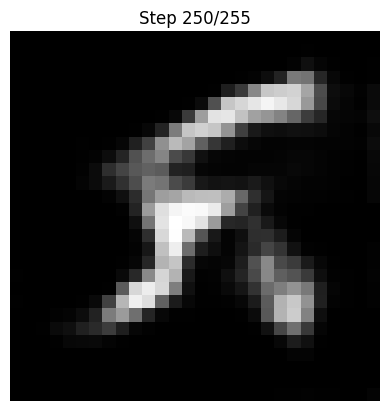

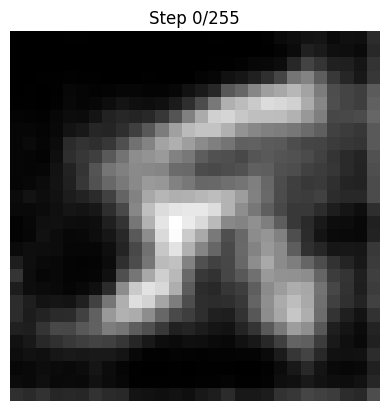

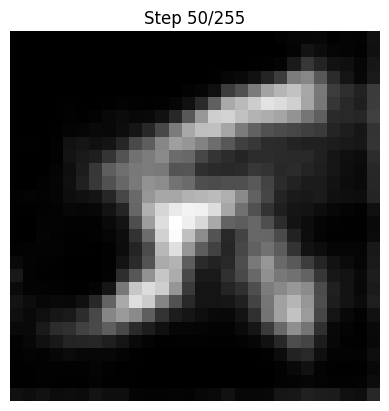

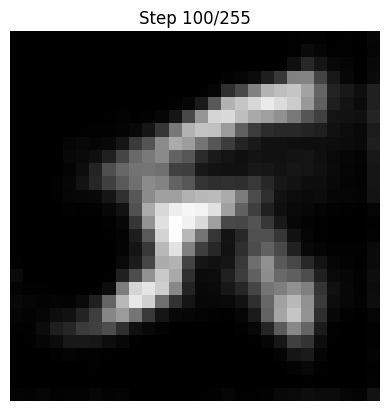

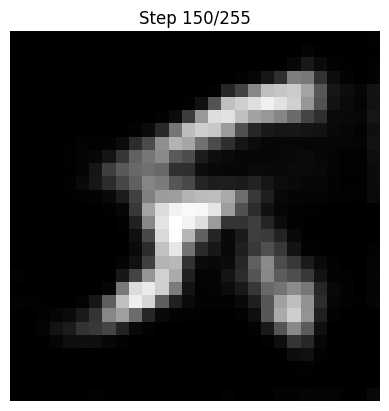

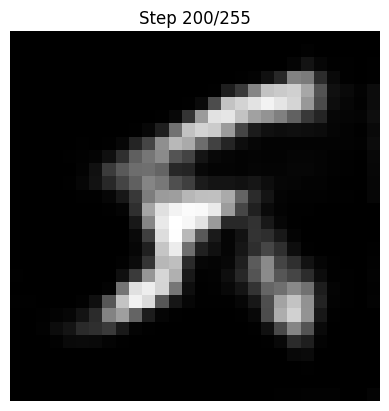

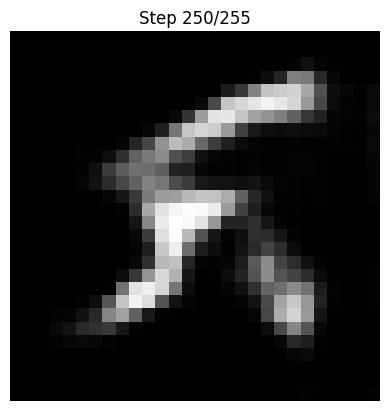

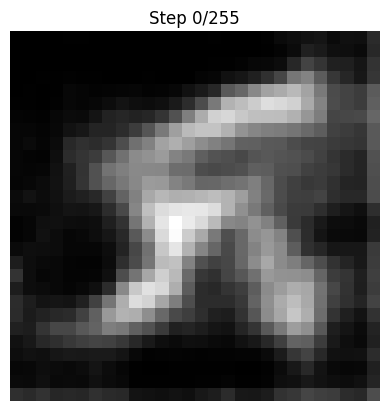

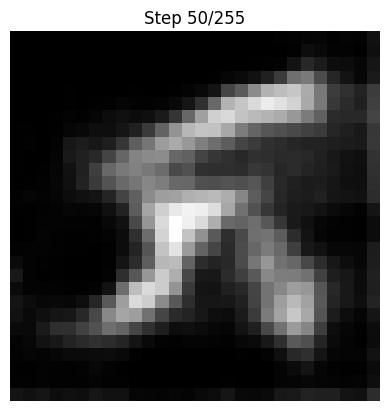

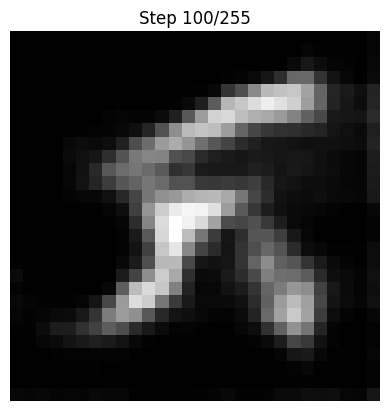

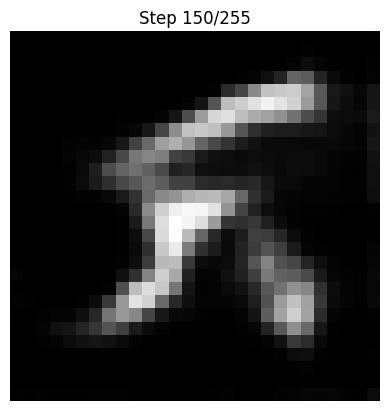

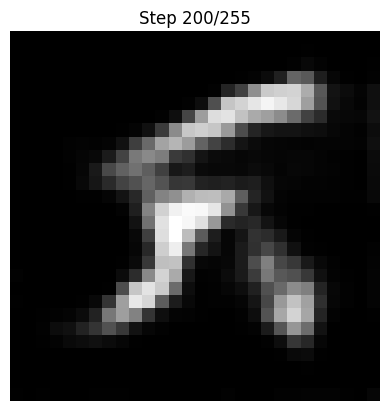

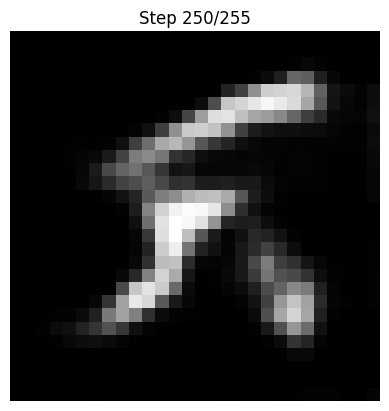

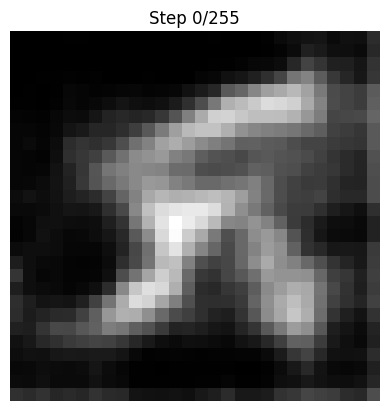

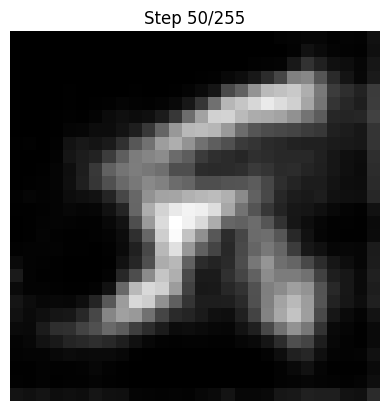

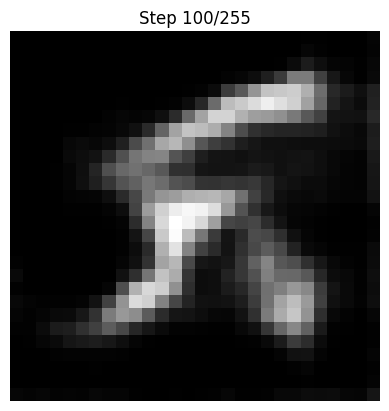

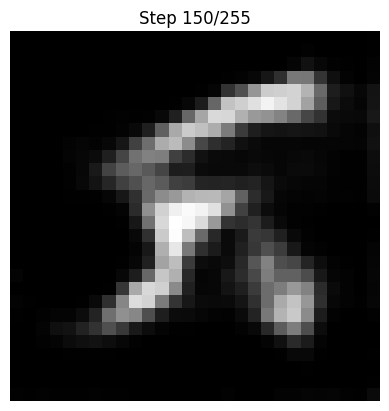

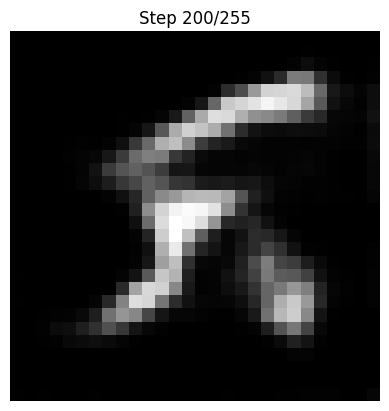

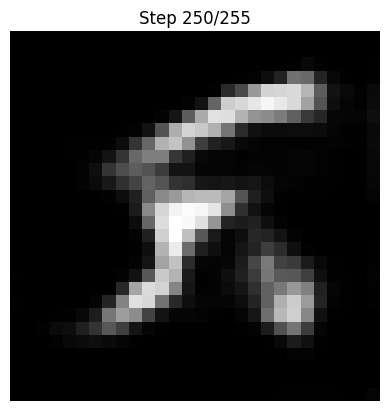

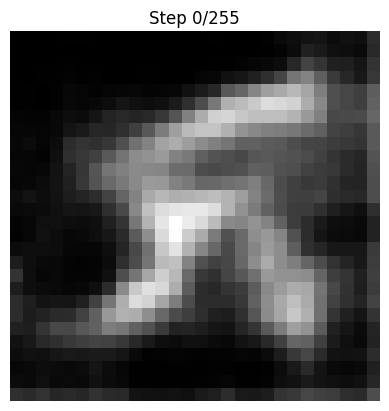

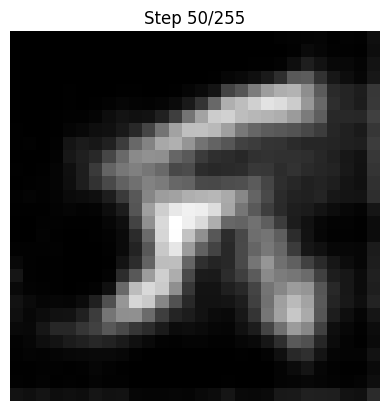

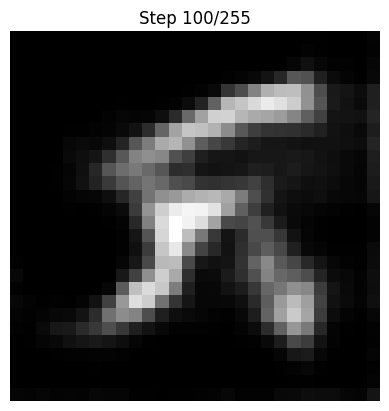

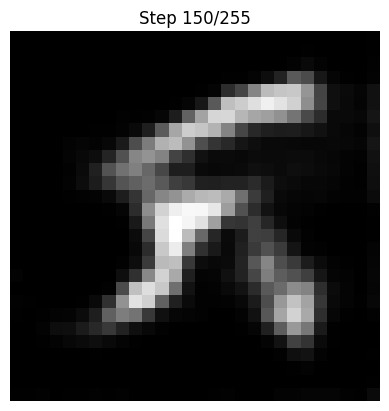

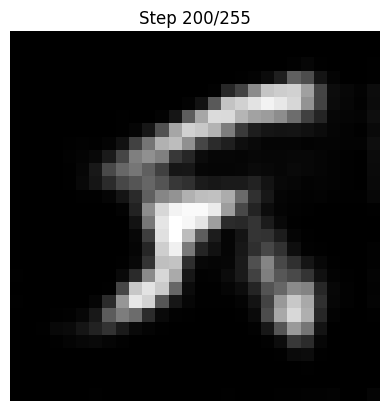

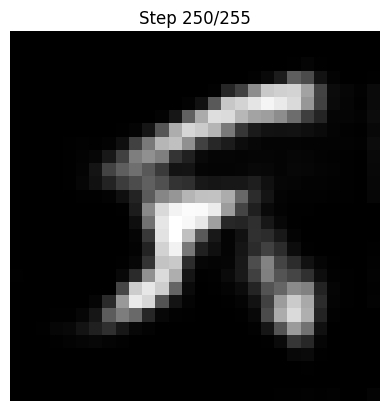

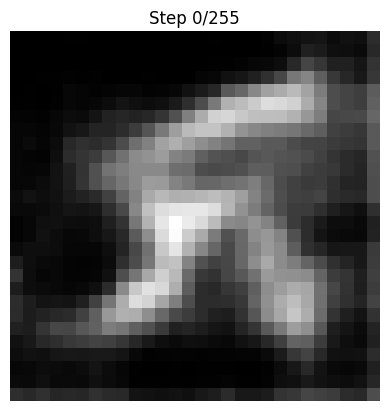

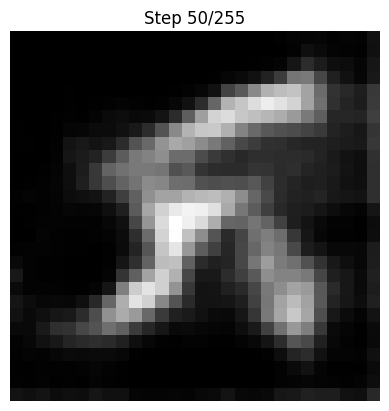

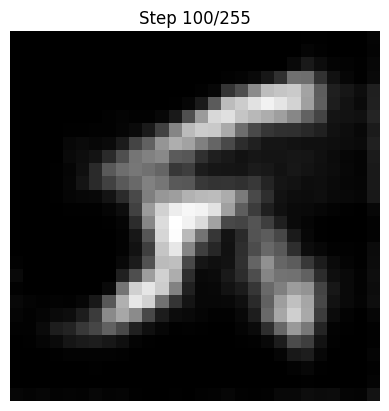

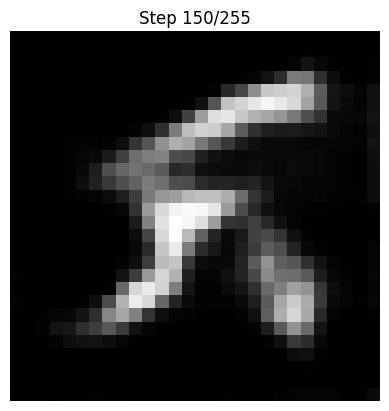

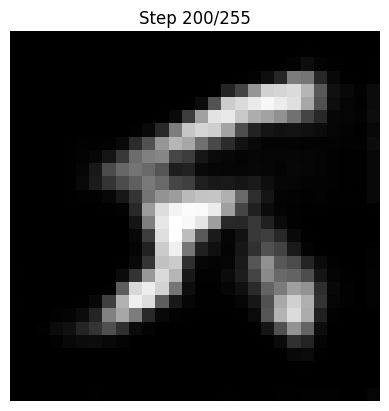

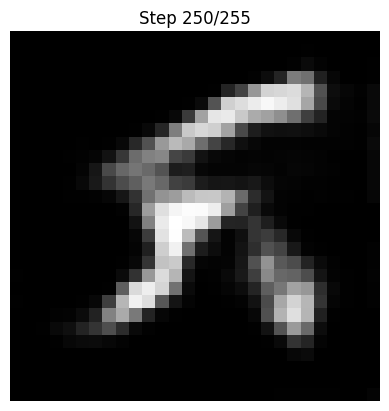

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys

class Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )
        self.latent_dim = latent_dim
        
    def forward(self, x):
        params = self.encoder(x)
        mu, log_var = params.chunk(2, dim=-1)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 7 * 7 * 32),
            nn.ReLU(),
            nn.Unflatten(-1, (32, 7, 7)),  # Changed unflatten dimension
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        if z.dim() == 1:
            z = z.unsqueeze(0)  
        return self.decoder(z)

class DiffusionModel:
    def __init__(self, n_steps=256, device='cpu'):
        self.n_steps = n_steps
        self.device = device
        betas = torch.linspace(1e-4, 0.02, n_steps).to(device)
        alphas = 1 - betas
        self.alphas_cumprod = torch.cumprod(alphas, dim=0)
        
    def add_noise(self, x, t):
        noise = torch.randn_like(x)
        alpha_t = self.alphas_cumprod[t]
        if alpha_t.dim() == 0:
            alpha_t = alpha_t.unsqueeze(0)
        return (
            torch.sqrt(alpha_t) * x + 
            torch.sqrt(1 - alpha_t) * noise
        ), noise
        
    def denoise_step(self, x, t):
        if isinstance(t, int):
            t = torch.tensor([t], device=x.device)
        alpha = self.alphas_cumprod[t]
        alpha_prev = self.alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0, device=x.device)
        
        eps = torch.randn_like(x)
        x_denoised = (1 / torch.sqrt(alpha)) * (x - torch.sqrt(1 - alpha) * eps)
        x_prev = torch.sqrt(alpha_prev) * x_denoised + torch.sqrt(1 - alpha_prev) * eps
        
        return x_prev

class DeepPCR:
    def __init__(self, diffusion_model, max_iter=10, tol=1e-4):
        self.diffusion = diffusion_model
        self.max_iter = max_iter
        self.tol = tol
        
    def parallel_denoise(self, x_noisy, n_steps, decoder=None):
        if x_noisy.dim() == 2:
            x_noisy = x_noisy.squeeze(0)
            
        x_steps = [x_noisy]
        
        for _ in range(n_steps - 1):
            x_steps.append(torch.randn_like(x_noisy))
            
        for iter_idx in range(self.max_iter):
            residuals = []
            for t in range(n_steps - 1):
                x_next = self.diffusion.denoise_step(x_steps[t], n_steps - t - 1)
                residual = x_steps[t + 1] - x_next
                residuals.append(torch.norm(residual).item())
                x_steps[t + 1] = x_next
                
                # Visualize every 50 steps
                if decoder and t % 50 == 0:
                    with torch.no_grad():
                        img = decoder(x_next).cpu()
                        plt.clf()
                        plt.imshow(img.squeeze(), cmap='gray')
                        plt.title(f'Step {t}/{n_steps-1}')
                        plt.axis('off')
                        plt.pause(0.01)
                
            if max(residuals) < self.tol:
                break
                
        return x_steps

def train_and_visualize():
    device = torch.device('cpu')
    latent_dim = 16
    n_steps = 256
    batch_size = 64
    num_epochs = 5
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    encoder = Encoder(latent_dim).to(device)
    decoder = Decoder(latent_dim).to(device)
    diffusion = DiffusionModel(n_steps=n_steps, device=device)
    deeppcr = DeepPCR(diffusion)
    
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
    
    plt.ion()
    plt.figure(figsize=(6, 6))
    
    for epoch in range(num_epochs):
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            
            latents = encoder(data)
            recon = decoder(latents)
            loss = F.mse_loss(recon, data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            sys.stdout.write(f'\rEpoch: {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
            sys.stdout.flush()
    
    z = torch.randn(latent_dim).to(device)
    noisy_latents, _ = diffusion.add_noise(z, torch.tensor(n_steps-1).to(device))
    denoised_steps = deeppcr.parallel_denoise(noisy_latents, n_steps, decoder)
    
    plt.ioff()
    plt.close()

if __name__ == "__main__":
    train_and_visualize()